<PIL.Image.Image image mode=RGB size=299x299 at 0x7FD306F361C0>


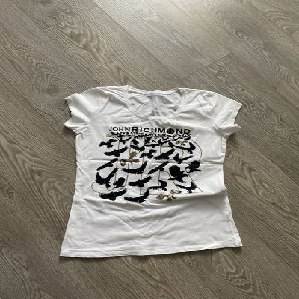

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
path = './clothing-dataset-small/train/t-shirt'
name = '01d1fed7-996d-496b-b3ae-73ab724f29cc.jpg'
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(299, 299))
print(img)
display(img)
imgArray = np.array(img)


In [15]:
# Pre-Trained Convolutional Neural Networks

# using existing model from https://keras.io/api/applications/xception/

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

model = Xception(weights='imagenet', input_shape=(299,299,3))

X = np.array([imgArray])
X = preprocess_input(X)
print(X.shape)
pred = model.predict(X)
print(pred.shape)

decode_predictions(pred)

(1, 299, 299, 3)
(1, 1000)
49152/35363 [=========================================] - 0s 1us/step


[[('n03595614', 'jersey', 0.6098826),
  ('n03188531', 'diaper', 0.045510035),
  ('n03958227', 'plastic_bag', 0.035615753),
  ('n03871628', 'packet', 0.020416792),
  ('n02730930', 'apron', 0.010919882)]]

In [100]:
# Convolutional Neural Networks

# Transfer Learning, train base model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

# generate data with augmentation. Generates more images by applying the image functions
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                rotation_range=30,
#                                width_shift_range=10.0,
#                                height_shift_range=10.0,
                               shear_range=10,
                               zoom_range=0.1,
                               vertical_flip=True)

train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', 
                                         target_size=(150,150), 
                                         batch_size=32)
print("Infered class_indices from folders:", train_ds.class_indices)
print()
print("Folders:")
!ls -l clothing-dataset-small/train

X, y = next(train_ds)



val_gen = ImageDataGenerator(preprocessing_function=preprocess_input) #no augmentation, we want realistic results

val_ds = val_gen.flow_from_directory('./clothing-dataset-small/validation', 
                                     target_size=(150,150), 
                                     batch_size=32,
                                     shuffle=False)

base_model = Xception(weights='imagenet', 
                      include_top=False, #don't include the dense layers
                     input_shape=(150,150,3))

base_model.trainable = False #freeze convolutional layers

Found 3068 images belonging to 10 classes.
Infered class_indices from folders: {'dress': 0, 'hat': 1, 'longsleeve': 2, 'outwear': 3, 'pants': 4, 'shirt': 5, 'shoes': 6, 'shorts': 7, 'skirt': 8, 't-shirt': 9}

Folders:
total 264
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 20480 Nov 15 22:53 dress
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 12288 Nov 15 22:53 hat
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 36864 Nov 15 22:53 longsleeve
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 20480 Nov 15 22:53 outwear
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 36864 Nov 15 22:53 pants
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 20480 Nov 15 22:53 shirt
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 20480 Nov 15 22:53 shoes
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 20480 Nov 15 22:53 shorts
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 12288 Nov 15 22:53 skirt
drwxrwxr-x 2 cristiandugacicu cristiandugacicu 69632 Nov 15 22:53 t-shirt
Found 341 images belonging to 10 classes.


In [54]:
# Build 4D model
inputs = keras.Input(shape=(150,150,3))
base = base_model(inputs, training=False)

outputs = base

model = keras.Model(inputs, outputs)
preds = model.predict(X)
print ("4D model shape:", preds.shape)

# Build 2D model
inputs = keras.Input(shape=(150,150,3))
base = base_model(inputs, training=False)
pooling=keras.layers.GlobalAveragePooling2D()
vectors = pooling(base)

outputs = vectors

model = keras.Model(inputs,outputs)
preds = model.predict(X)
print ("2D model shape:", preds.shape)

4D model shape: (32, 5, 5, 2048)
2D model shape: (32, 2048)


In [56]:
# Build dense layer:
inputs = keras.Input(shape=(150,150,3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs,outputs)
preds = model.predict(X)
preds.shape

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 132s 1s/step - loss: 1.2278 - accuracy: 0.6718 - val_loss: 0.9955 - val_accuracy: 0.7067
Epoch 2/10
96/96 [==============================] - 125s 1s/step - loss: 0.6202 - accuracy: 0.8132 - val_loss: 0.8333 - val_accuracy: 0.7537
Epoch 3/10
96/96 [==============================] - 139s 1s/step - loss: 0.3291 - accuracy: 0.8866 - val_loss: 0.8586 - val_accuracy: 0.7918
Epoch 4/10
96/96 [==============================] - 108s 1s/step - loss: 0.2553 - accuracy: 0.9140 - val_loss: 0.9065 - val_accuracy: 0.7713
Epoch 5/10
96/96 [==============================] - 115s 1s/step - loss: 0.1634 - accuracy: 0.9430 - val_loss: 0.9272 - val_accuracy: 0.7859
Epoch 6/10
96/96 [==============================] - 109s 1s/step - loss: 0.1386 - accuracy: 0.9492 - val_loss: 0.8669 - val_accuracy: 0.8182
Epoch 7/10
96/96 [==============================] - 107s 1s/step - loss: 0.1014 - accuracy: 0.9648 - val_loss: 0.9202 - val_accuracy: 0.7889
Epoch 8/10
96

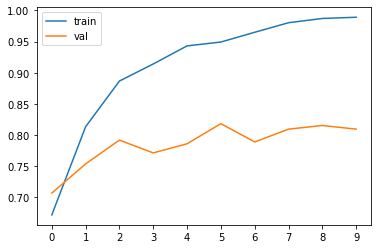

In [58]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [91]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

def make_model(learning_rate=0.01, size_inner=10, droprate=0.5):
    base_model = Xception(weights='imagenet', 
                          include_top=False, #don't include the dense layers
                          input_shape=(150,150,3))

    base_model.trainable = False #freeze convolutional layers

    ### Build architecture:
    
    inputs = keras.Input(shape=(150,150,3))

    base = base_model(inputs, training=False)
    
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner) #regularization to drop percetage of data when training (to randomly exclude logos)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs,outputs)

    ### Build model:
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

# try different learing rates:
scores = {}
for lr in [0.0001, 0.001, 0.01]:
    print("lr =",lr)
    model = make_model(lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

lr = 0.0001
Epoch 1/10
 4/96 [>.............................] - ETA: 1:02 - loss: 2.6550 - accuracy: 0.0469

KeyboardInterrupt: 

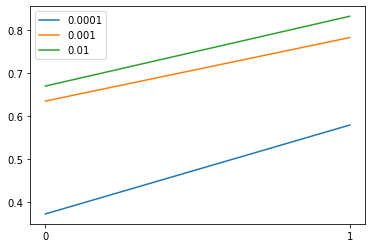

In [66]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=lr)
#     plt.plot(hist['val_accuracy'], label=lr)
    
plt.xticks(np.arange(10))
plt.legend()

In [70]:
# Checkpointing
# model.save_weights('model_v1.h5', save_format='h5')

learning_rate = 0.001
checkpoint = keras.callbacks.ModelCheckpoint('xception_v01_{epoch:02d}_{val_accuracy:.3f}.h5',
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='auto')
model = make_model(learning_rate)
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                    callbacks=[checkpoint])



Epoch 1/10
96/96 [==============================] - 126s 1s/step - loss: 1.1079 - accuracy: 0.6366 - val_loss: 0.7044 - val_accuracy: 0.8065


/home/cristiandugacicu/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
96/96 [==============================] - 138s 1s/step - loss: 0.6245 - accuracy: 0.7894 - val_loss: 0.6126 - val_accuracy: 0.7977
Epoch 3/10
96/96 [==============================] - 138s 1s/step - loss: 0.5060 - accuracy: 0.8295 - val_loss: 0.5855 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 141s 1s/step - loss: 0.4270 - accuracy: 0.8644 - val_loss: 0.5587 - val_accuracy: 0.8182
Epoch 5/10
96/96 [==============================] - 139s 1s/step - loss: 0.3720 - accuracy: 0.8859 - val_loss: 0.5515 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 131s 1s/step - loss: 0.3243 - accuracy: 0.9058 - val_loss: 0.5340 - val_accuracy: 0.8182
Epoch 7/10
96/96 [==============================] - 120s 1s/step - loss: 0.2883 - accuracy: 0.9218 - val_loss: 0.5629 - val_accuracy: 0.8240
Epoch 8/10
96/96 [==============================] - 144s 2s/step - loss: 0.2629 - accuracy: 0.9345 - val_loss: 0.5310 - val_accuracy: 0.8387
Epoch 9/10
15

KeyboardInterrupt: 

0.0001
Epoch 1/2
96/96 [==============================] - 137s 1s/step - loss: 1.5791 - accuracy: 0.5081 - val_loss: 1.2258 - val_accuracy: 0.6070
Epoch 2/2
96/96 [==============================] - 120s 1s/step - loss: 1.0171 - accuracy: 0.6679 - val_loss: 0.9037 - val_accuracy: 0.7126
0.0001
Epoch 1/2
96/96 [==============================] - 133s 1s/step - loss: 1.0076 - accuracy: 0.6666 - val_loss: 0.7333 - val_accuracy: 0.7478
Epoch 2/2
96/96 [==============================] - 111s 1s/step - loss: 0.5216 - accuracy: 0.8126 - val_loss: 0.6230 - val_accuracy: 0.7889
0.0001
Epoch 1/2
96/96 [==============================] - 116s 1s/step - loss: 0.9477 - accuracy: 0.6933 - val_loss: 0.6112 - val_accuracy: 0.8211
Epoch 2/2
96/96 [==============================] - 109s 1s/step - loss: 0.4449 - accuracy: 0.8452 - val_loss: 0.6714 - val_accuracy: 0.7889


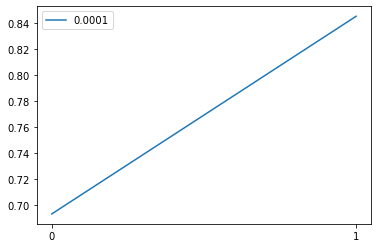

In [73]:
# Adding More Layers

learning_rate = 0.001
scores = {}

for size in [10, 100, 1000]:
    print(lr)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=2, validation_data=val_ds)
    scores[lr] = history.history
    
for size, hist in scores.items():
    plt.plot(hist['accuracy'], label=size)
#     plt.plot(hist['val_accuracy'], label=lr)
    
plt.xticks(np.arange(2))
plt.legend()    

In [96]:
# Regularization
# A OLX logo on a Tshirt trains the model that the logo means TShirt. This is incorrect.
# playing with droprate

learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(size)
    model = make_model(learning_rate=learning_rate,
                       size_inner=size,
                       droprate=droprate)
    history = model.fit(train_ds, epochs=3, validation_data=val_ds)
    scores[droprate] = history.history
    
    

100
Epoch 1/3
96/96 [==============================] - 121s 1s/step - loss: 0.9803 - accuracy: 0.6705 - val_loss: 0.6664 - val_accuracy: 0.7947
Epoch 2/3
96/96 [==============================] - 120s 1s/step - loss: 0.5233 - accuracy: 0.8116 - val_loss: 0.6058 - val_accuracy: 0.8035
Epoch 3/3
96/96 [==============================] - 120s 1s/step - loss: 0.3788 - accuracy: 0.8696 - val_loss: 0.5702 - val_accuracy: 0.8094
100
Epoch 1/3
96/96 [==============================] - 114s 1s/step - loss: 0.9776 - accuracy: 0.6737 - val_loss: 0.6503 - val_accuracy: 0.8094
Epoch 2/3
96/96 [==============================] - 115s 1s/step - loss: 0.5342 - accuracy: 0.8123 - val_loss: 0.6160 - val_accuracy: 0.8152
Epoch 3/3
96/96 [==============================] - 121s 1s/step - loss: 0.3707 - accuracy: 0.8794 - val_loss: 0.5883 - val_accuracy: 0.8152
100
Epoch 1/3
96/96 [==============================] - 115s 1s/step - loss: 0.9849 - accuracy: 0.6685 - val_loss: 0.6419 - val_accuracy: 0.8006
Epoch 2/

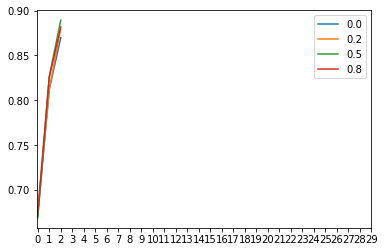

In [99]:
for dr, hist in scores.items():
    plt.plot(hist['accuracy'], label=dr)
#     plt.plot(hist['val_accuracy'], label=dr)
    
plt.xticks(np.arange(30))
plt.legend()

In [117]:
# Test best model on test dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

best_model = keras.models.load_model('xception_v01_08_0.839.h5')

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299,299),
    batch_size=32,
    shuffle=False
)

best_model.evaluate(test_ds)

Found 372 images belonging to 10 classes.
12/12 [==============================] - 60s 5s/step - loss: 0.9598 - accuracy: 0.7285


[0.9597958922386169, 0.7284946441650391]

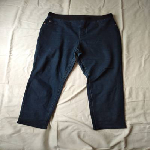

(1, 150, 150, 3)


{'dress': -4.154631,
 'hat': -5.073421,
 'longsleeve': -2.1718457,
 'outwear': -2.072346,
 'pants': 5.8675065,
 'shirt': -4.4015203,
 'shoes': -6.4486446,
 'shorts': -0.3632183,
 'skirt': -6.9688516,
 't-shirt': -4.326434}

In [131]:
# Apply best model to an image
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(150,150))
display(img)

x = np.array(img)
X = np.array([x])
print(X.shape)

X = preprocess_input(X)

pred = best_model.predict(X)
types = train_ds.class_indices.keys()
dict(zip(types, pred[0]))